# Dueling - DQN


### References:

Please follow [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) for the original publication as well as the psuedocode.

In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('CartPole-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print("State shape:", state_shape)
print("Number of Actions: ",no_of_actions)
print("Sampled Action",env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print("Current_State: ",state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print("Sampled Action2: ", action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print("Next_State: ",next_state)
print("Reward: ",reward)
print("Done: ", done)
print("Info: ", info)
print("----")


State shape: 4
Number of Actions:  2
Sampled Action 1
----
Current_State:  [-0.04456399  0.04653909  0.01326909 -0.02099827]
----
Sampled Action2:  1
----
Next_State:  [-0.04363321  0.24146826  0.01284913 -0.30946528]
Reward:  1.0
Done:  False
Info:  {}
----


## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components.

### Q-Network:
The neural network used as a function approximator is defined below

In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import torch
import numpy as np
from collections import deque, namedtuple

from scipy.special import softmax

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
'''BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)'''

class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, algo_type=1, num_common_layers =1,num_common_layer_units= 64,num_val_layers=1,num_val_layer_units=128,num_adv_layers=1,num_adv_layer_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.algo_type = algo_type
        activation = nn.LeakyReLU
        self.fcs = nn.Sequential(*[nn.Linear(state_size, num_common_layer_units),activation()])
        self.fc_common = nn.Sequential(*[nn.Sequential(*[nn.Linear(num_common_layer_units,num_common_layer_units),activation()]) for _ in range(num_common_layers-1)])
        self.fc_adv_start = nn.Sequential(*[nn.Linear(num_common_layer_units,num_adv_layer_units),activation()])
        self.fc_val_start = nn.Sequential(*[nn.Linear(num_common_layer_units,num_val_layer_units),activation()])
        self.fc_adv_hidden = nn.Sequential(*[nn.Sequential(*[nn.Linear(num_adv_layer_units,num_adv_layer_units),activation()]) for _ in range(num_adv_layers-1)])
        self.fc_val_hidden = nn.Sequential(*[nn.Sequential(*[nn.Linear(num_val_layer_units,num_val_layer_units),activation()]) for _ in range(num_val_layers-1)])
        self.fc_advantage = nn.Linear(num_adv_layer_units, action_size)
        self.fc_value = nn.Linear(num_val_layer_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        xs = self.fcs(state)
        x_common = self.fc_common(xs)
        x_adv_start = self.fc_adv_start(x_common)
        x_val_start = self.fc_val_start(x_common)
        x_adv_hidden = self.fc_adv_hidden(x_adv_start)
        x_val_hidden = self.fc_val_hidden(x_val_start)
        Val = self.fc_value(x_val_hidden)
        Adv = self.fc_advantage(x_adv_hidden)

        if(self.algo_type==1):
          advAverage = torch.mean(Adv, dim=1, keepdim=True)
          return Val+Adv-advAverage
        elif(self.algo_type==2):
          adv_max, adv_max_ind = torch.max(Adv, dim=1, keepdim=True)
          return Val+Adv-adv_max

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class TutorialAgent():

    def __init__(self, state_size, action_size, seed, algo_type=1,exploration='epsilon', BUFFER_SIZE = int(1e2), BATCH_SIZE = 32, GAMMA = 0.99, LR = 1e-3, UPDATE_EVERY = 20, num_common_layers =1,num_common_layer_units= 256,num_val_layers=1,num_val_layer_units=256,num_adv_layers=1,num_adv_layer_units=256 ):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.exploration = exploration
        self.BUFFER_SIZE = BUFFER_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.LR = LR
        self.UPDATE_EVERY = UPDATE_EVERY

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed, algo_type=algo_type, num_common_layers = num_common_layers,num_common_layer_units= num_common_layer_units,num_val_layers=num_val_layers,num_val_layer_units=num_val_layer_units,num_adv_layers=num_adv_layers,num_adv_layer_units=num_adv_layer_units).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed, algo_type=algo_type, num_common_layers = num_common_layers,num_common_layer_units= num_common_layer_units,num_val_layers=num_val_layers,num_val_layer_units=num_val_layer_units,num_adv_layers=num_adv_layers,num_adv_layer_units=num_adv_layer_units).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= self.BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, self.GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if(self.exploration == 'softmax'):
          ''' Softmax action selection '''
          tau = 10*eps
          Prob = softmax(action_values.cpu().data.numpy()/tau)
          return random.choices(np.arange(self.action_size),weights=Prob[0])[0]
        else:
          ''' Epsilon-greedy action selection (Already Present) '''
          if random.random() > eps:
              return np.argmax(action_values.cpu().data.numpy())
          else:
              return random.choice(np.arange(self.action_size))


    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        '''for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)'''

        self.optimizer.step()

### Here, we present the DQN algorithm code.

In [4]:
''' Defining DQN Algorithm '''

def dqn(agent, n_episodes=500, max_t=1000, eps_start=0.5, eps_end=0.001, eps_decay=0.995):
    Rewards = []
    Regret = 0
    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        Rewards.append(score)
        Regret+=(500-score)
        scores_window.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    #print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    return Rewards


Episode 100	Average Score: 166.85
Episode 200	Average Score: 388.77
Episode 300	Average Score: 422.74
Episode 400	Average Score: 392.02
Episode 500	Average Score: 450.62
Episode 600	Average Score: 496.94
Episode 700	Average Score: 480.15
Episode 800	Average Score: 494.16
Episode 900	Average Score: 471.30
Episode 1000	Average Score: 486.34
Episode 100	Average Score: 225.57
Episode 200	Average Score: 328.58
Episode 300	Average Score: 466.13
Episode 400	Average Score: 489.63
Episode 500	Average Score: 422.00
Episode 600	Average Score: 477.93
Episode 700	Average Score: 456.16
Episode 800	Average Score: 446.16
Episode 900	Average Score: 475.58
Episode 1000	Average Score: 488.38
Episode 100	Average Score: 204.52
Episode 200	Average Score: 363.67
Episode 300	Average Score: 462.59
Episode 400	Average Score: 460.25
Episode 500	Average Score: 431.00
Episode 600	Average Score: 483.61
Episode 700	Average Score: 475.29
Episode 800	Average Score: 472.31
Episode 900	Average Score: 481.79
Episode 1000

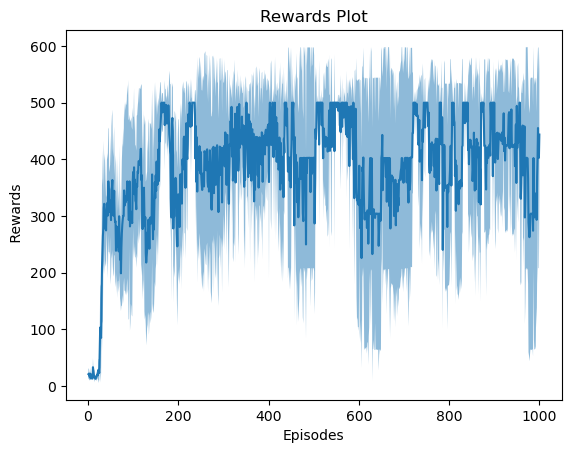

In [6]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

num_exp = 5
max_episodes = 1000
total_rewards_type1 = np.zeros([num_exp,max_episodes])
for i in range(num_exp):
    env = gym.make('CartPole-v1')
    env.seed(i)
    state = env.reset()
    agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = i, algo_type=1,exploration="softmax", BUFFER_SIZE = int(1e5), BATCH_SIZE = 128, GAMMA = 0.99, LR = 1e-4, UPDATE_EVERY = 20, num_common_layers =2,num_common_layer_units= 256,num_val_layers=1,num_val_layer_units=256,num_adv_layers=1,num_adv_layer_units=256)
    curr_rewards = dqn(agent,n_episodes=max_episodes,eps_start=0.5,eps_end=0.001,eps_decay=0.95)
    #agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = i, algo_type=1, BUFFER_SIZE = int(1e2), BATCH_SIZE = 32, GAMMA = 0.99, LR = 1e-4, UPDATE_EVERY = 20, num_common_layers =2,num_common_layer_units= 256,num_val_layers=1,num_val_layer_units=256,num_adv_layers=1,num_adv_layer_units=256)
    #curr_rewards = dqn(agent,n_episodes=max_episodes,eps_start=0.5,eps_end=0.001,eps_decay=0.9)
    total_rewards_type1[i] = curr_rewards
Regret_type1 = np.mean(np.sum(500-total_rewards_type1,axis=1),axis=0)
print("\nRegret =", Regret_type1)
rewards_mean_type1 = np.mean(total_rewards_type1,axis=0)
reward_std_type1 = np.std(total_rewards_type1, axis=0)
plt.plot(np.arange(1,len(rewards_mean_type1)+1),rewards_mean_type1)
plt.fill_between(np.arange(1,len(rewards_mean_type1)+1),rewards_mean_type1 - reward_std_type1,rewards_mean_type1 + reward_std_type1, alpha=0.5)
plt.xlabel("Episodes")
plt.ylabel(" Rewards")
plt.title("Rewards Plot")
plt.show()

In [7]:
import pandas as pd
data = np.vstack([rewards_mean_type1,reward_std_type1]).T
dff= pd.DataFrame(np.array(data),columns = ["Mean","Std"])
dff.to_csv("DDQN_T1_CartPole_0730.csv", index = False)

# Final Draft

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'avg_regret'},
 'parameters': {'act_algorithm': {'values': ['softmax', 'epsilon']},
                'batch_size': {'values': [32, 64, 128]},
                'buffer_size': {'values': [100, 500, 1000, 10000]},
                'epsilon_tau_decay': {'values': [0.995, 0.95, 0.9, 0.85]},
                'epsilon_tau_start': {'values': [1, 0.5]},
                'lr': {'values': [0.01, 0.001, 0.0001]},
                'num_common_layer_units': {'values': [64, 128, 256]},
                'num_common_layers': {'values': [1, 2, 3]},
                'type': {'values': [1]},
                'update_every': {'values': [10, 20, 30]}}}
Create sweep with ID: qxxi8syy
Sweep URL: https://wandb.ai/nayinisriharsh-iitm/CS6700_PROGRAMMING_ASSIGNMENT_2/sweeps/3iha1id2

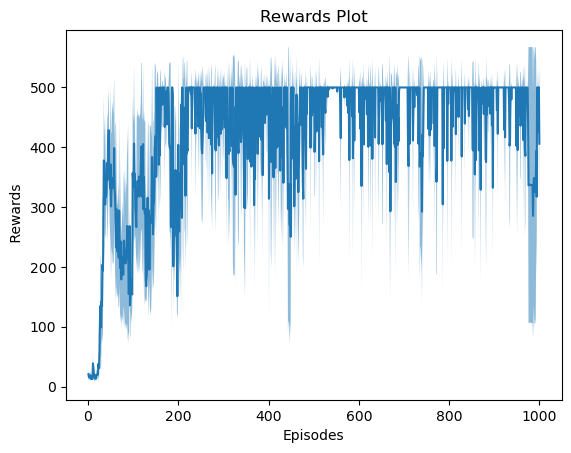

In [8]:
#Regret_type1 = np.mean(np.sum(500-total_rewards_type1,axis=1),axis=0)
#print("\nRegret =", Regret_type1)
rewards_mean_temp = np.mean(total_rewards_type1[0:3],axis=0)
reward_std_temp = np.std(total_rewards_type1[0:3],axis=0)
plt.plot(np.arange(1,len(rewards_mean_temp)+1),rewards_mean_temp)
plt.fill_between(np.arange(1,len(rewards_mean_temp)+1),rewards_mean_temp - reward_std_temp,rewards_mean_temp + reward_std_temp, alpha=0.5)
plt.xlabel("Episodes")
plt.ylabel(" Rewards")
plt.title("Rewards Plot")
plt.show()